In [1]:
import numpy as np

# import qutip as qt
import torch
from torch.utils.data import Dataset, DataLoader
import joblib

import torch.nn as nn
import matplotlib.pyplot as plt

from torch import tensor

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
raw_data = joblib.load("raw_data.job").real.swapaxes(1, 2)

In [6]:
class CNNDensityMatrix(nn.Module):
    def __init__(
        self, no_channels, no_filters, kernel_window, timeseries_length
    ):
        super(CNNDensityMatrix, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=no_channels,
            out_channels=no_filters,
            kernel_size=kernel_window,
        )
        # len_output_of_conv1d = timeseries_length - kernel_window + 1
        # self.fc1 = nn.Linear(len_output_of_conv1d * no_filters, no_channels)
        self.fc1 = nn.Linear(no_filters, no_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.fc1(x.permute(0, 2, 1)).permute(0, 2, 1)
        return x


class DensityMatrixDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = (self.X[idx], self.y[idx])
        return sample

In [31]:
N = raw_data.shape[0]
C = raw_data.shape[1]
L = raw_data.shape[2]

no_filters = 16

kernel_window = 4


model = CNNDensityMatrix(
    no_channels=C,
    no_filters=no_filters,
    kernel_window=kernel_window,
    timeseries_length=L,
)

model = model.to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


print(model)

CNNDensityMatrix(
  (conv1): Conv1d(4, 16, kernel_size=(4,), stride=(1,))
  (fc1): Linear(in_features=16, out_features=4, bias=True)
)


In [32]:
X_raw = raw_data
y_raw = raw_data[:, :, kernel_window - 1 :]

dataset = DensityMatrixDataset(X_raw, y_raw)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [33]:
num_epochs = 500  # Number of training epochs

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        X, y_true = data
        X = X.to(device)
        y_true = y_true.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        y_hat = model(X)
        loss = criterion(y_true, y_hat)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:  # Print every 10 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3e}")
            running_loss = 0.0

print("Finished Training")

[1, 10] loss: 6.973e-02
[2, 10] loss: 4.394e-02
[3, 10] loss: 2.122e-02
[4, 10] loss: 6.523e-03
[5, 10] loss: 1.739e-03
[6, 10] loss: 1.266e-03
[7, 10] loss: 1.163e-03
[8, 10] loss: 1.052e-03
[9, 10] loss: 9.475e-04
[10, 10] loss: 8.821e-04
[11, 10] loss: 8.077e-04
[12, 10] loss: 7.494e-04
[13, 10] loss: 7.064e-04
[14, 10] loss: 6.472e-04
[15, 10] loss: 6.117e-04
[16, 10] loss: 6.007e-04
[17, 10] loss: 5.566e-04
[18, 10] loss: 5.284e-04
[19, 10] loss: 5.042e-04
[20, 10] loss: 4.775e-04
[21, 10] loss: 4.481e-04
[22, 10] loss: 4.256e-04
[23, 10] loss: 4.178e-04
[24, 10] loss: 4.062e-04
[25, 10] loss: 3.767e-04
[26, 10] loss: 3.652e-04
[27, 10] loss: 3.556e-04
[28, 10] loss: 3.315e-04
[29, 10] loss: 3.259e-04
[30, 10] loss: 3.108e-04
[31, 10] loss: 3.090e-04
[32, 10] loss: 2.784e-04
[33, 10] loss: 2.746e-04
[34, 10] loss: 2.570e-04
[35, 10] loss: 2.493e-04
[36, 10] loss: 2.391e-04
[37, 10] loss: 2.219e-04
[38, 10] loss: 2.111e-04
[39, 10] loss: 2.090e-04
[40, 10] loss: 1.928e-04
[41, 10] 

KeyboardInterrupt: 

In [43]:
all_preds = model(tensor(X_raw).to(device)).cpu().detach().numpy()

In [44]:
all_true = y_raw

all_preds = model(tensor(X_raw).to(device)).cpu().detach().numpy()

rng = np.random.default_rng(seed=0)

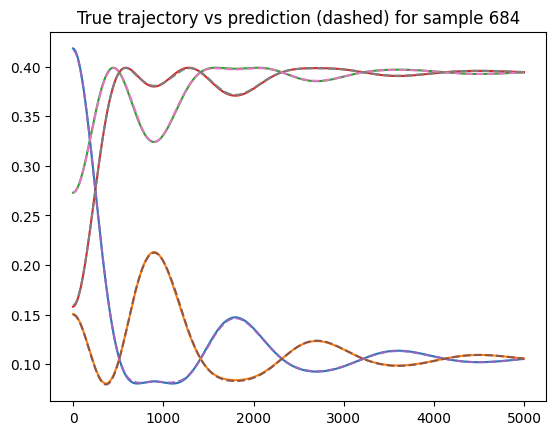

In [102]:
i = rng.integers(0, N - 1)

plt.plot(all_true[i].T)
plt.plot(all_preds[i].T, "--")
plt.title(f"True trajectory vs prediction (dashed) for sample {i}")
plt.show()